In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import requests

import pandas as pd
import random
import numpy as np

covid_path = os.path.join('/content','drive','My Drive','covid')


In [47]:
rilevazioni = pd.read_csv('/content/drive/My Drive/IT/Python/covid/rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni.iloc[:,15:]

23-03  24-03  25-03  ...  03-04  04-04  05-04
Regione   Citta                                 ...                     
LOMBARDIA BERGAMO           6471   6728   7072  ...   9315   9588   9712
          BRESCIA           5905   6298   6597  ...   9014   9180   9340
          COMO               581    635    706  ...   1256   1319   1384
          CREMONA           2925   3061   3156  ...   4097   4154   4233
          LECCO              934   1015   1076  ...   1594   1628   1678
...                          ...    ...    ...  ...    ...    ...    ...
CALABRIA  COSENZA             68     84     99  ...    203    204    230
          REGGIO CALABRIA     94     97    105  ...    218    222    237
          CATANZARO           46     49     51  ...    150    150    157
          VIBO VALENTIA       20     21     23  ...     54     57     60
          CROTONE             62     66     71  ...    106    106    109

[108 rows x 14 columns]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(15, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  ax.set_xticks(ticks=np.arange(0, len(df.columns), step=1))
  ax.set_xticklabels(list(df.columns))

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

In [0]:
sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]

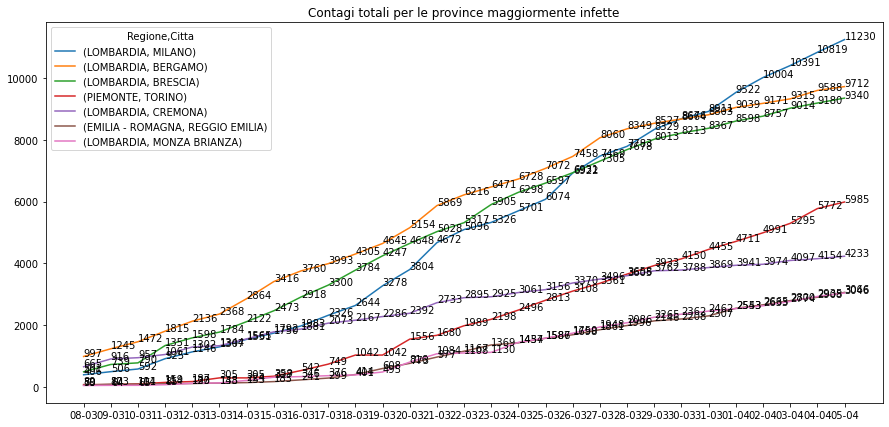

In [50]:
_ = plot_annotate(sorted_by_infections.head(7),'Contagi totali per le province maggiormente infette')

In [0]:
crescita = pd.DataFrame(index=sorted_by_infections.index)

In [0]:
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

In [53]:
display(crescita.head(3))
sorted_by_infections.head(3)

09-03  10-03  11-03  12-03  ...  02-04  03-04  04-04  05-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    482    387    428    411
          BERGAMO    248    227    343    321  ...    132    144    273    124
          BRESCIA    238     51    561    247  ...    159    257    166    160

[3 rows x 28 columns]

08-03  09-03  10-03  11-03  ...  02-04  03-04  04-04  05-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     406    506    592    925  ...  10004  10391  10819  11230
          BERGAMO    997   1245   1472   1815  ...   9171   9315   9588   9712
          BRESCIA    501    739    790   1351  ...   8757   9014   9180   9340

[3 rows x 29 columns]

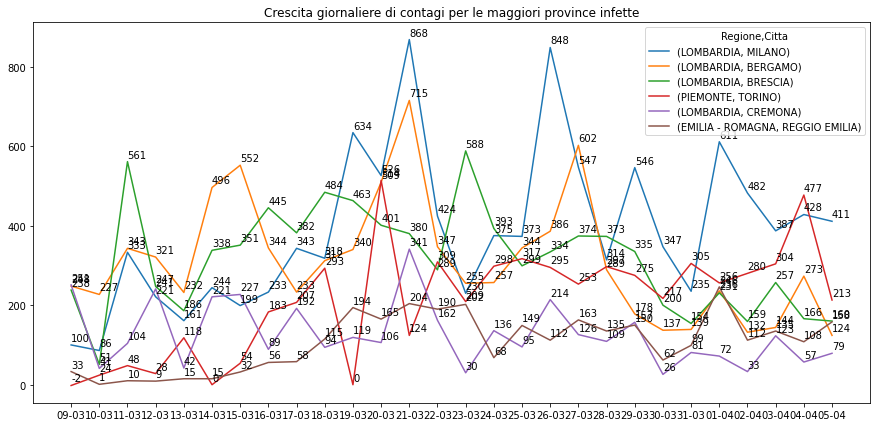

In [54]:
_ = plot_annotate(crescita.head(6), 'Crescita giornaliere di contagi per le maggiori province infette')

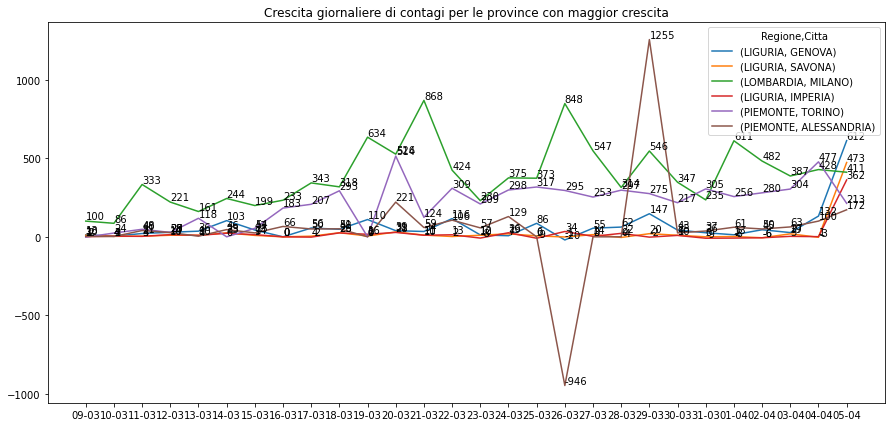

In [79]:
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(6),
                   'Crescita giornaliere di contagi per le province con maggior crescita')
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

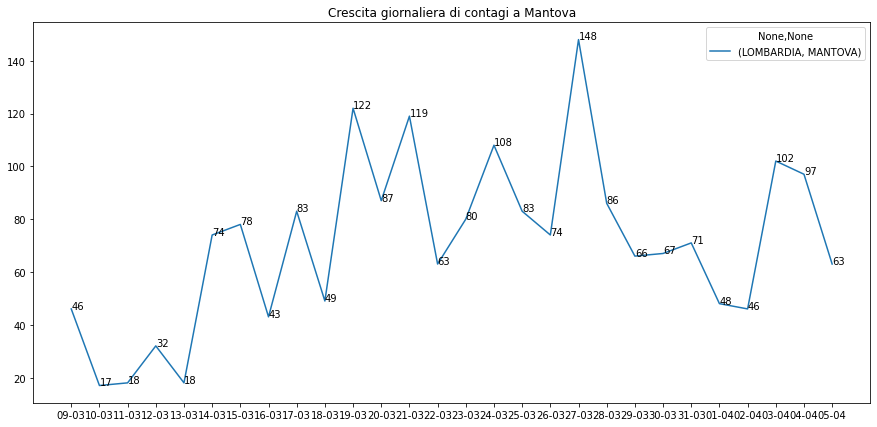

In [56]:
_ = plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Crescita giornaliera di contagi a Mantova', ydelta=0)

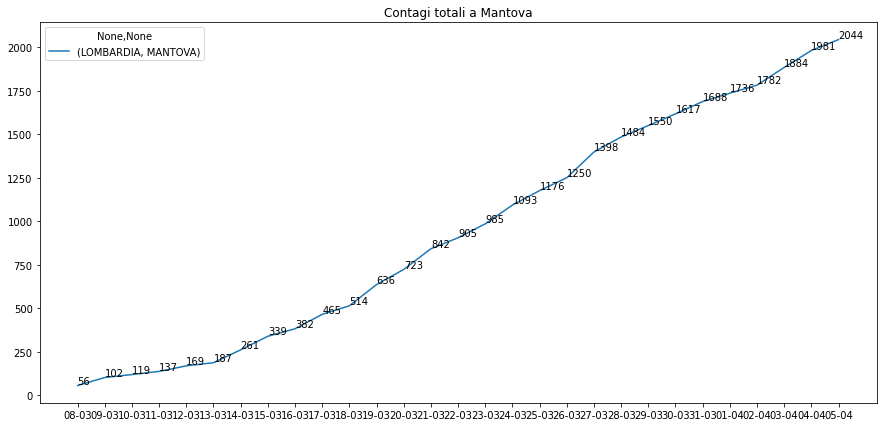

In [57]:
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Contagi totali a Mantova')

# Average 3 days

In [0]:
avg3 = pd.DataFrame(index=sorted_by_infections.index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)

In [0]:
avg3 = avg3.astype('int32')

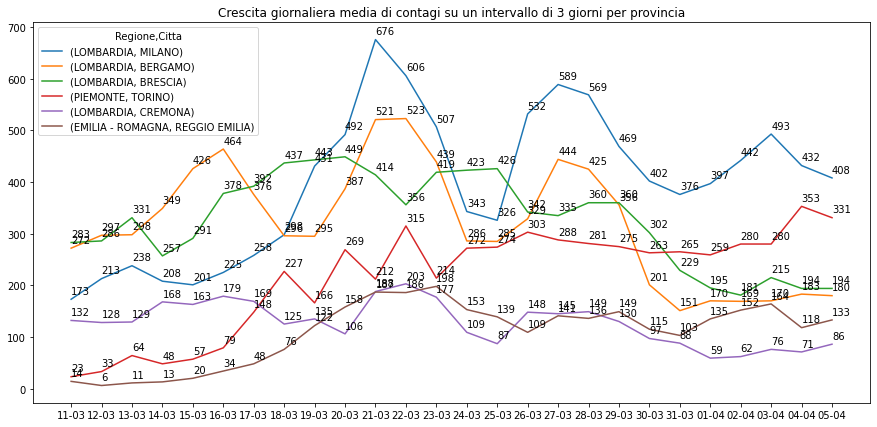

In [60]:
_ = plot_annotate(avg3.head(6), 'Crescita giornaliera media di contagi su un intervallo di 3 giorni per provincia')

In [0]:
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']

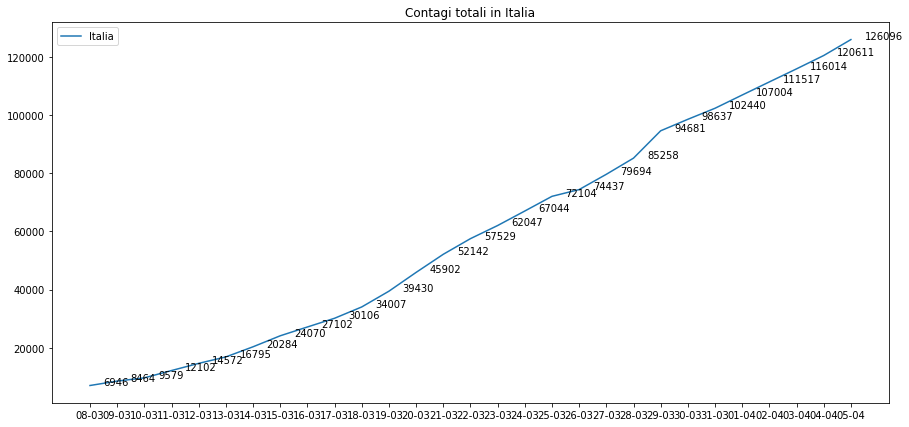

In [62]:
_ = plot_annotate(casi_italia, 'Contagi totali in Italia', xdelta=0.5)

In [0]:
crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']

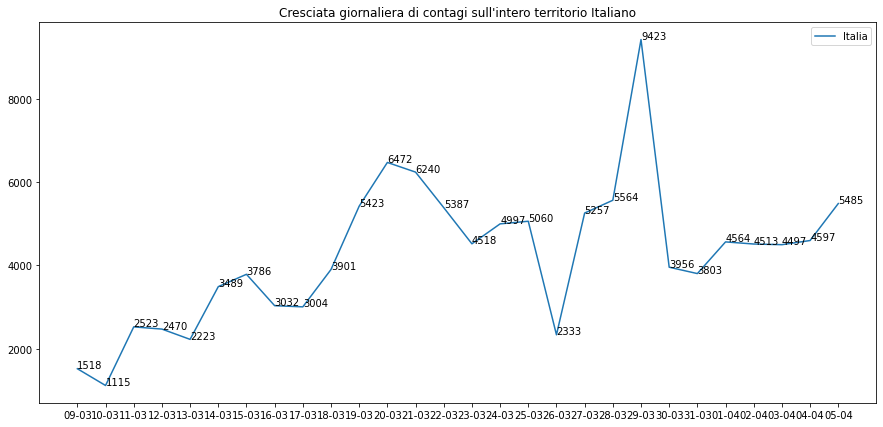

In [64]:
_ = plot_annotate(crescita_italia, 'Cresciata giornaliera di contagi sull\'intero territorio Italiano')

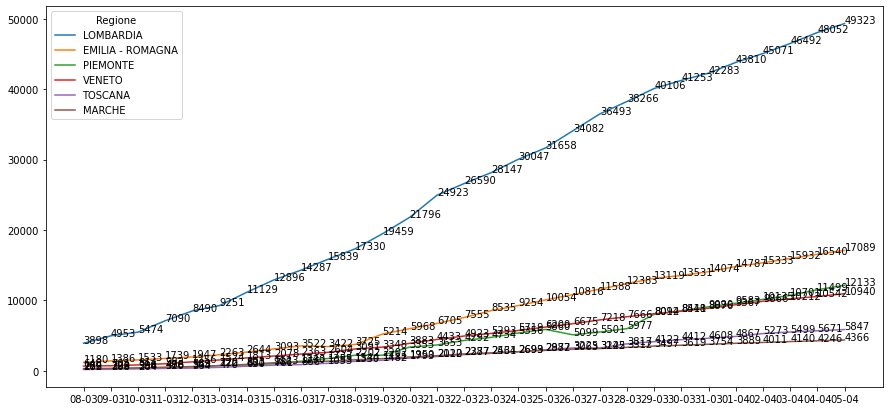

In [65]:
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
_ = plot_annotate(regioni.head(6))

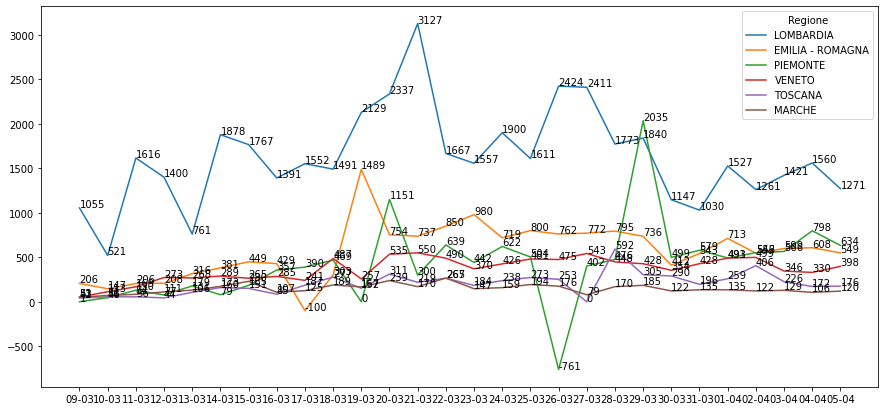

In [66]:
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(6))
